# Weather file - gap filling and formatting
- Main tasks: 
    1. gap fill weather file
    2. combine met and solrad info into single files for each site-year
    3. address timezone issue
    4. format weather file into MAIZSIM-readable format
- Data source: 
    1. weadata/**temp_all.csv**
    2. weadata/**rh_all.csv**
    3. weadata/**precip_all.csv**
    4. weadata/**solrad_all.csv**
- Main output: 
    - weadata/data/control/**site_year.txt** - weather file for all site-years

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import xarray as xr
import datetime
import time 
from timezonefinder import TimezoneFinder
import pytz

### Step 0: Reading in temperature, precip, RH & solar radiation data:
- Main input:
    - /weadata/**temp_all.csv**
    - /weadata/**rh_all.csv**
    - /weadata/**precip_all.csv**
    - /weadata/**solrad_all.csv**
- Main output: 
    - **df_temp, df_rh, df_precip, df_solrad**

In [13]:
# reading in compiled met & solrad data from weafile_read
df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col=0)
df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col=0)
df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col=0)
df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv', index_col=0)

# processing solar radiation data to only include growing season
df_solrad = df_solrad.reindex(df_temp.index)

# checking that all met elements aligned - dataframe shape should match
print(df_temp.shape)
print(df_rh.shape)
print(df_precip.shape)
print(df_solrad.shape)

# saving the updated solar radiation data
#df_solrad.to_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_all.csv')

(197310, 237)
(197310, 237)
(197310, 237)
(197310, 237)


### Step 1. Figure out valid site-years that can be gap-filled
Selecting for site-years based on **crit_hrs** - consecutive missing hours of datapoints within raw data
- Main input: **df_temp, df_precip, df_solrad**
- Main output: **finalist**

In [600]:
# input variables for loop
datasets = list([df_temp, df_precip, df_solrad]) # weather datasets to process
                                                 # df_rh is based off df_temp, so no need to evaluate 

finalist = list([[], [], []]) # final lists to store processed output
                              # order: [0]-temp, [1]-precip, [2]-solrad

years = np.arange(1961, 1991) # years

growseason_start = '-04-01 00:00:00' # setting up growing season# 
growseason_end = '-10-31 23:00:00' # *** maybe want to change this to earlier, -03-01 00:00:00

crit_hrs = 1 # critical hrs of missing data


# loop through temp, precip & solrad dataset to pick out usable site-years
for i in np.arange(len(datasets)):
    dataset = datasets[i]
    siteyears_all = list()
    sites = dataset.columns
    
    for j in years:
        start_time = str(j) + growseason_start
        end_time = str(j) + growseason_end
        siteyears = list()
        
        for k in sites:
            df = dataset.loc[start_time:end_time, k] 
            df = pd.DataFrame(df)
            df['group'] = df.notnull().astype(int) # df.notnull() returns TRUE or FALSE, 
                                                   # .astype(int) turns TRUE into 1, and FALSE into 0
            df['group'] = df.group.cumsum() # calculating cumulative sum 
            df = df[df.iloc[:,0].isnull()] # selecting out individual timesteps that have missing data
            df['count'] = df.groupby('group')['group'].transform('size') # counts the number of consecutive NANs 
            df = df.drop_duplicates('group')
            
            if df[df['count'] > crit_hrs].shape[0] == 0:
                use_siteyear = str(j) + '_' + str(k)
                siteyears.append(use_siteyear) # only record site-years that have fewer consecutive NANs than the critical value set
        
        siteyears_all.extend(siteyears)
    
    finalist[i] = siteyears_all


### Step 2. Compare usable site-years for temp  & precip and find the common year-sites
- Main intput: **finalist**
- Main output: **yearsites**

In [601]:
yearsites_temp = finalist[0]
yearsites_rh = finalist[1]
yearsites_precip = finalist[2]
yearsites_solrad = finalist[3]

print('temp:', len(yearsites_temp))
print('precip:', len(yearsites_precip))
print('solrad:', len(yearsites_solrad))

yearsites = list(set(yearsites_temp) & set(yearsites_rh))
yearsites = list(set(yearsites) & set(yearsites_precip))
yearsites = list(set(yearsites) & set(yearsites_solrad))

yearsites.sort()

print('overlapping siteyears:', len(yearsites))

temp: 2838
precip: 2254
solrad: 7097
overlapping siteyears: 2125


In [561]:
#crithrs_0 = len(yearsites)
#crithrs_1 = len(yearsites)
#crithrs_2 = len(yearsites)
#crithrs_3 = len(yearsites)

### Step 3. Visualization - available site-years vs. consecutive missing data hours

<BarContainer object of 4 artists>

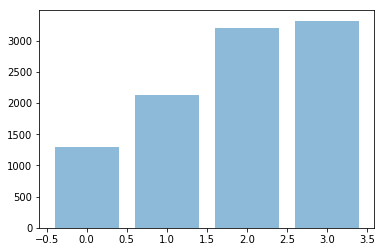

In [562]:
x = [0,1,2,3]
width =  [crithrs_0, crithrs_1, crithrs_2, crithrs_3]
plt.bar(x, width, alpha=0.5)

### Step 4. Sotre basic info of valid site-years
- Main input: **yearsites**
- Main output: 
    - weadata/**site_year_crithr1.csv** - site-year info for data filtered with crithr = 1
    - weadata/**site_year.csv** - info on how many years of wea data each site has

In [603]:
# what are the valid site-years?
years = list()
sites = list()

for i in range(len(yearsites)):
    year = yearsites[i][0:4]
    years.append(year)
    site = yearsites[i][5:10]
    sites.append(site)

df_yearsites = pd.DataFrame({'site': sites, 'year': years}, 
                            columns=['site', 'year'])
df_yearsites = df_yearsites.sort_values(['site', 'year'])
final_sites = list(set(df_yearsites.site))
#df_yearsites.to_csv('../weadata/site_year_crithr1.csv')

In [299]:
# how many years of data does each site have?
numofyears = list()

for i in final_sites:
    years = len(df_yearsites[df_yearsites["site"] == i])
    numofyears.append(years)
    
df_numofyears = pd.DataFrame({"site": final_sites, "years": numofyears})
df_numofyears = df_numofyears.sort_values(["site"])
df_numofyears = df_numofyears.reset_index().iloc[:, 1:3]
#df_numofyears.to_csv("../weadata/site_years.csv")

### Step 5: Compile and gap-fill usable site-years data into individual weather data files
- Main tasks:
    - figure out time zone for individual site and convet wea data from UTC into local time
    - gap-fill wea data by linearly interpolating with data from hour before and after
- Main input:
    - /weadata/**site_info.csv** - city, state, lat, lon info for each site
    - /weadata/**site_year_crithr1.csv** - site-year info for data filtered with crithr = 1
    - df_temp, df_rh, df_precip, df_solrad
- Main output:
    - /weadata/data/control/**site_year.txt** - MAIZSIM weather file for every site-year
- Functions:
    - find_zone(site)
    - utc_to_local(times, zone)

In [24]:
# time zone finder
def find_zone(site):
    """
    find time zone for specific sites
    """
    lat = float(siteinfo[siteinfo.site == site].lat)
    lon = float(siteinfo[siteinfo.site == site].lon) * -1
    tf = TimezoneFinder()    
    zone = tf.timezone_at(lng=lon, lat=lat)
    return zone

In [15]:
# utc conversion to local time
def utc_to_local(times, zone):
    """
    convert list of utc timestamps into local time
    """
    times = times.to_pydatetime() # convert from pd.DatetimeIndex into python datetime format
    utc = pytz.timezone('UTC') # setting up the UTC timezone, requires package 'pytz'
    local_datetime = list()
    
    for time in times:
        utctime = utc.localize(time) # adding UTC timezone to datetime
        localtime = utctime.astimezone(pytz.timezone(zone)) 
        datetime = pd.to_datetime(localtime)
        local_datetime.append(datetime)
        
    return local_datetime

In [ ]:
%%time # code block run time ~52 mins

### setting up growing season period
season_start, season_end = '04-01', '10-31'

### reading in required files
siteinfo = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_info.csv', dtype='str', usecols=[1,2,3,4,5])
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr1.csv', dtype='str', usecols=[1,2])
siteyear = siteyear[siteyear.site != '41415'] # dropping out Guam within dataset

### starting the loop to process each site-year
for i in np.arange(siteyear.shape[0]): 
    # selecting site-year combinations
    site = siteyear.iloc[i,0]
    year = siteyear.iloc[i,1]
    print(site, year)
    
    # constructing dataframe that will hold all weather data
    col = ['jday','date','hour','solrad','temp','precip','rh', 'co2']
    df_wea = pd.DataFrame(columns=col)

    # setting up for time-relating entries
    times = pd.date_range(season_start + '-' + str(year), 
                          season_end + '-' + str(year)+ ' 23:00:00', freq='1H') # utc time
    zone = find_zone(site)
    local_datetime = utc_to_local(times, zone)
            
    # selecting weather data
    utc_start, utc_end = str(times[0]), str(times[-1])
    df_wea.temp = list(df_temp[utc_start:utc_end][site])
    df_wea.rh = list(np.round((df_rh[utc_start:utc_end][site])*100, 2))
    df_wea.precip = list(df_precip[utc_start:utc_end][site]/10) #*** this is a temporary fix for precip scaling bug
    df_wea.co2 = 400    

    # selecting solar radiation 
    t1 = pd.to_datetime(utc_start).to_pydatetime()
    t2 = pd.to_datetime(utc_end).to_pydatetime()
    tdiff = t2-t1
    local_start = str(local_datetime[0])[:19] 
    local_end = str(pd.to_datetime(local_start).to_pydatetime() + tdiff)[:19]
    df_wea.solrad = list(df_solrad[local_start:local_end][site])

    # adding time-relating info to data frame
    local = pd.date_range(local_start, local_end, freq='H')
    df_wea.jday = local.dayofyear
    df_wea.date = local.strftime("'%m/%d/%Y'")
    df_wea.hour = local.hour    
    
    # gap-filling weather data
    if df_wea.isna().sum().sum() > 0:
        # creating a log file that documents the number of missing data for each site-year
        f = open('/home/disk/eos8/ach315/upscale/weadata/data/log.txt', 'a+')
        f.write('site: %s' %siteyear.iloc[i,:][0])
        f.write(', year: %s' %siteyear.iloc[i,:][1])
        f.write(', gap-filled: %s\r\n' %df_wea.isna().sum().sum())
        f.close()
        
        # gap-filling data by linearly interpolating with data from hour before and after
        df_wea = df_wea.interpolate() 
        
    # saving individual site-year weather file into .csv 
#    df_wea.to_csv('/home/disk/eos8/ach315/upscale/weadata/data/control/' + site + '_' + year + '.txt', sep='\t', index=False)
    

### Step 6: Final step of gap-filling if needed

Since pd.interpolate() cannot gap-fill missing data if the missing data is located at the very beginning of the data (nan in first row), the code checks whether there are site-years with that situation, and if so assigns the missing data in the first row a default number.

In [1354]:
fnames = glob.glob('/home/disk/eos8/ach315/upscale/weadata/data/control/*')

for name in fnames: 
    df_wea = pd.read_csv(name)
    df_wea = df_wea.drop(df_wea.columns[0], axis=1)
    if df_wea.isna().sum().sum() > 0:
        print(name.split('/')[-1], df_wea.isna().sum().sum())

# no files required additional gap-filling

### Step 7: reading in a final compiled weather file to check output

In [25]:
test = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/data/control/24127_1989.txt', sep='\t')
test.head()

,jday,date,hour,solrad,temp,precip,rh,co2
0,90,'03/31/1989',17,29.0,7.8,0.0,76.18,400
1,90,'03/31/1989',18,4.0,5.6,1.3,85.04,400
2,90,'03/31/1989',19,0.0,6.1,2.5,88.77,400
3,90,'03/31/1989',20,0.0,6.1,0.0,85.69,400
4,90,'03/31/1989',21,0.0,6.1,0.0,82.13,400


### Step *. Select for subset dataset to include only valid (can be gap-filled) weather data
**** JH 200506- thinking about whehter to keep this or not ****
- Main task:
- Main input: 
    - /weadata/**site_year_crithr1.csv**
    - /weadata/**temp_all.csv**
    - /weadata/**precip_all.csv**
    - /weadata/**rh_all.csv**
    - /weadata/**solrad_all.csv**
- Main output: **/weadata/weadata.csv** - 

In [34]:
# reading in data
siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr1.csv', dtype="str")
siteyear = siteyear.drop(siteyear.columns[0], axis=1)
print('total site-years:', siteyear.shape[0])

total site-years: 2125


In [ ]:
# 190923: still thinking whether the code below in this step 5 section is necessary now
# Read in individual weather data files and merge them into long form data frame:

filelist = ['temp_all.csv', 'precip_all.csv', 'rh_all.csv', 'solrad_all.csv']
weavars = ['temp', 'precip', 'rh', 'solrad']
filenums = len(filelist)
dfs = [[],[],[],[]]
sites = sorted(list(set(siteyear.site)))
grow_months = [5,6,7,8,9,10]

for i in range(filenums):
    dfs[i] = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/' + filelist[i], index_col=0)
    dfs[i].index = pd.to_datetime(dfs[i].index) # converting index timepoint into datetimeindex
    dfs[i] = dfs[i][dfs[i].index.month.isin(grow_months)] # selecting only the growing season timepoints
    dfs[i] = dfs[i].filter(items=sites, axis=1) # selcting only the valid sites
    dfs[i]["date"] = dfs[i].index # creating another column that stores datetimeindex info, for melting purpose
    dfs[i] = pd.melt(dfs[i], id_vars="date", var_name="sites", value_name=weavars[i])

df = pd.merge(dfs[0], dfs[1])
df = pd.merge(df, dfs[2])
df = pd.merge(df, dfs[3])    

df.index = pd.to_datetime(df.date)
df = df.iloc[:, 1:]
df.head()

In [ ]:
# selecting for valid site-years
valid_siteyears = siteyear.shape[0]
frames = []

for i in range(valid_siteyears):
    dfi = df[df.index.year == int(siteyear.year[i])]
    dfi = dfi[dfi.sites == siteyear.site[i]]
    frames.append(dfi)
#    print(len(frames)) # since this code takes time to run, 
                       # this helps to see where in the process it is

df_valid = pd.concat(frames)
# saving all valid weather dataframe into .csv
#df_valid.to_csv("/home/disk/eos8/ach315/upscale/weadata/weadata.csv")

In [36]:
test = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/weadata.csv', index_col=0)
test.head()

,sites,temp,precip,rh,solrad
date,,,,,
1964-05-01 00:00:00,3103,9.4,0.0,0.605071,0.0
1964-05-01 01:00:00,3103,5.6,15.0,0.850413,0.0
1964-05-01 02:00:00,3103,4.4,0.0,0.925122,0.0
1964-05-01 03:00:00,3103,3.3,0.0,0.924547,0.0
1964-05-01 04:00:00,3103,2.8,0.0,0.924283,0.0
